### Отслеживание тренировочного процесса 

In [2]:
from theory.linear_algebra import Vector

def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

assert num_differences([1, 2, 3], [2, 1, 3]) == 2
assert num_differences([1, 2], [1, 2]) == 0


### Вычисление средних кластеров

In [3]:
from typing import List
from theory.linear_algebra import vector_mean
import random

def clusters_means(k: int,
                   inputs: List[Vector],
                   assignments: List[int]) -> List[Vector]:
    # clusters[i] содержит входы, чье назначение равно i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # Если кластер пустой, то просто взять случайную точку
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]

### Наш кластер

In [4]:
import itertools
import random
import tqdm
from theory.linear_algebra import squared_distance

class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k  # Число кластеров
        self.means = None

    def classify(self, input: Vector) -> int:
        """Вернуть индекс кластера, ближайшего к входному значению"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))
    
    def train(self, inputs: List[Vector]) -> None:
        # Начать со случайных назначений
        assignments = [random.randrange(self.k) for _ in inputs]
        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Вычислить средние и отыскать новые назначения
                self.means = clusters_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input)
                                   for input in inputs]
                
                # Проверить, сколько назначений изменилось,
                # и если нисколько, то работа завершена
                num_changed = num_differences(assignments,
                                              new_assignments)
                if num_changed == 0:
                    return
                
                # В противном случае оставить новые назначения
                # и вычислить новые средние
                assignments = new_assignments
                self.means = clusters_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")
                


## Пример 1: встречи специалистов


In [5]:
inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

random.seed(12)
clusterer = KMeans(k=3)
clusterer.train(inputs)
means = sorted(clusterer.means) # Отсортировать для модульного теста

assert len(means) == 3

# Проверить, что средние находятся близко к тому, что мы ожидаем
assert squared_distance(means[0], [-44, 5]) < 1
assert squared_distance(means[1], [-16, -10]) < 1
assert squared_distance(means[2], [18, 20]) < 1


changed: 5 / 20: : 1it [00:00, 1497.43it/s]


In [6]:
random.seed(0)
clusterer = KMeans(k=2)
clusterer.train(inputs)
means = sorted(clusterer.means)

assert len(means) == 2
assert squared_distance(means[0], [-26, -5]) < 1
assert squared_distance(means[1], [18, 20]) < 1

changed: 4 / 20: : 2it [00:00, 1834.38it/s]


### Выбор числа k

In [7]:
from matplotlib import pyplot as plt

def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
    """Отыскивает сумму квадратов ошибок, возникающих 
       из кластеризации входов k средним"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

### Применим это к предыдущему примеру

0it [00:00, ?it/s]
changed: 8 / 20: : 1it [00:00, 1400.44it/s]
changed: 2 / 20: : 2it [00:00, 1316.07it/s]
changed: 2 / 20: : 2it [00:00, 1797.43it/s]
changed: 2 / 20: : 4it [00:00, 1752.92it/s]
changed: 1 / 20: : 3it [00:00, 1573.65it/s]
changed: 1 / 20: : 5it [00:00, 1647.93it/s]
changed: 4 / 20: : 2it [00:00, 1368.90it/s]
changed: 2 / 20: : 3it [00:00, 1268.82it/s]
changed: 4 / 20: : 3it [00:00, 1213.28it/s]
changed: 1 / 20: : 3it [00:00, 1043.27it/s]
changed: 1 / 20: : 3it [00:00, 1248.18it/s]
changed: 1 / 20: : 3it [00:00, 1056.06it/s]
changed: 1 / 20: : 3it [00:00, 1060.15it/s]
changed: 1 / 20: : 4it [00:00, 1110.78it/s]
changed: 3 / 20: : 3it [00:00, 949.87it/s]
changed: 1 / 20: : 4it [00:00, 1006.98it/s]
changed: 3 / 20: : 3it [00:00, 918.53it/s]
changed: 3 / 20: : 3it [00:00, 793.52it/s]
changed: 1 / 20: : 5it [00:00, 924.38it/s]


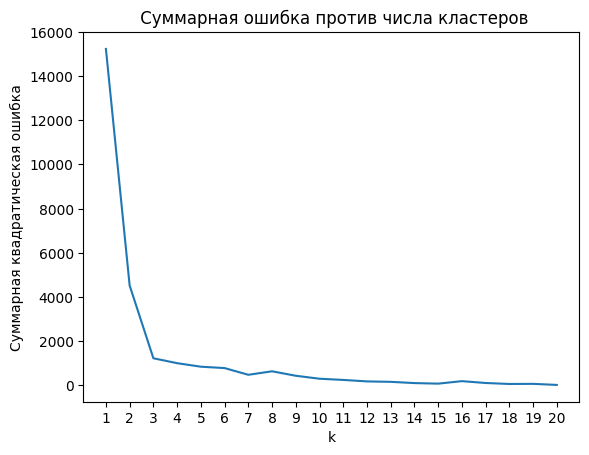

In [8]:
ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]
plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("Суммарная квадратическая ошибка")
plt.title(" Суммарная ошибка против числа кластеров")
plt.show()

## Пример 2: кластеризация цвета

In [9]:
image_path = r"data/vovan.jpg"

In [10]:
import matplotlib.image as mpimg
img = mpimg.imread(image_path) / 256    # Прошкалировать между 0 и 1

#### img[i][j] - это пиксель в i-й строке и j-ом столбце, причем каждый пиксель - это список [red, green, blue] чисел в диапазоне от 0 до 1, которые обозначают цвет пикселя

In [11]:
top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue = top_left_pixel

In [12]:
# .tolist() конвертирует массив NumPy в список Python
pixels = [pixel.tolist() for row in img for pixel in row]

clusterer = KMeans(5)
clusterer.train(pixels)

changed: 49 / 3499200: : 18it [08:01, 26.75s/it]    


In [13]:
def recolor(pixel: Vector) -> Vector:
    cluster = clusterer.classify(pixel)
    return clusterer.means[cluster]

new_img = [[recolor(pixel) for pixel in row]
           for row in img]

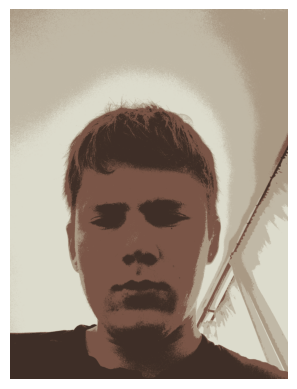

In [14]:
plt.imshow(new_img)
plt.axis('off')
plt.show()

## Восходящая иерархическая кластеризация

In [15]:
from typing import NamedTuple, Union

class Leaf(NamedTuple):
    value: Vector

leaf1 = Leaf([10, 20])
leaf2 = Leaf([30, -15])

In [16]:
class Merged(NamedTuple):
    children: tuple
    order: int

merged = Merged((leaf1, leaf2), order=1)

Cluster = Union[Leaf, Merged]

### Ф-ия, которая рекурсивно возвращает все значения, содержащиеся в кластере

In [17]:
def get_values(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]
    
assert get_values(merged) == [[10, 20], [30, -15]]

### Будем использовать минимальное расстояние м/у элементами двух кластеров

In [18]:
from typing import Callable
from theory.linear_algebra import distance

def cluster_distance(cluster1: Cluster,
                     cluster2: Cluster,
                     distance_agg: Callable = min) -> float:
    """
    Вычислить все попарные расстояния между cluster1 и cluster2
    и применить агрегатную функцию _distance_agg_
    к результирующем списку
    """
    return distance_agg([distance(v1, v2)
                         for v1 in get_values(cluster1)
                         for v2 in get_values(cluster2)])


In [19]:
def get_merge_order(cluster: Cluster) -> float:
    if isinstance(cluster, Leaf):
        return float('inf')  # Ни разу не объединялся
    else:
        return cluster.order

In [20]:
from typing import Tuple

def get_children(cluster: Cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Лист не имеет дочерних элементов")
    else:
        return cluster.children

### Кластерный алгоритм

In [ ]:
def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min) -> Cluster:
    # Начать с того, что все элементы являются листьями
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair: Tuple[Cluster, Cluster]) -> float:
        return cluster_distance(pair[0], pair[1], distance_agg)

    # До тех пор, пока у нас осталось более одного кластера
    while len(clusters) > 1:
        # Отыскать два ближайших кластера
        c1, c2 = min(((cluster1, cluster2)
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # Удалить их из списка кластеров
        clusters = [c for c in clusters if c != c1 and c != c2]

        # Объединить их, используя merge_order = число оставшихся кластеров
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # И добавить их объединение
        clusters.append(merged_cluster)

    # Когда остался всего один кластер, вернуть его
    return clusters[0]

base_cluster = bottom_up_cluster(inputs)

Merged(children=(Merged(children=(Merged(children=(Merged(children=(Merged(children=(Leaf(value=[19, 28]), Leaf(value=[21, 27])), order=18), Leaf(value=[20, 23])), order=14), Leaf(value=[26, 13])), order=3), Merged(children=(Leaf(value=[11, 15]), Leaf(value=[13, 13])), order=16)), order=1), Merged(children=(Merged(children=(Merged(children=(Merged(children=(Merged(children=(Leaf(value=[-49, 0]), Leaf(value=[-46, 5])), order=11), Leaf(value=[-41, 8])), order=9), Leaf(value=[-49, 15])), order=5), Leaf(value=[-34, -1])), order=4), Merged(children=(Merged(children=(Merged(children=(Merged(children=(Leaf(value=[-22, -16]), Leaf(value=[-19, -11])), order=10), Leaf(value=[-25, -9])), order=8), Merged(children=(Merged(children=(Merged(children=(Leaf(value=[-11, -6]), Leaf(value=[-12, -8])), order=17), Leaf(value=[-14, -5])), order=15), Leaf(value=[-18, -3])), order=13)), order=7), Merged(children=(Leaf(value=[-13, -19]), Leaf(value=[-9, -16])), order=12)), order=6)), order=2)), order=0)

### Ф-ия для генерации любого числа кластеров

In [25]:
def generate_clusters(base_cluster: Cluster,
                      num_clusters: int) -> List[Cluster]:
    # Начать со списка, состоящего только из базового кластера
    clusters = [base_cluster]

    # До тех пор, пока у нас недостаточно кластеров...
    while len(clusters) < num_clusters:
        # Выбрать из кластеров тот, который был объединен последним
        next_cluster = min(clusters, key=get_merge_order)
        # Удалить его из списка
        clusters = [c for c in clusters if c != next_cluster]

        # И добавить его дочерние элементы в список (т.е. разделить его)
        clusters.extend(get_children(next_cluster))

    # Как только у нас достаточно кластеров
    return clusters

### Пример использования 

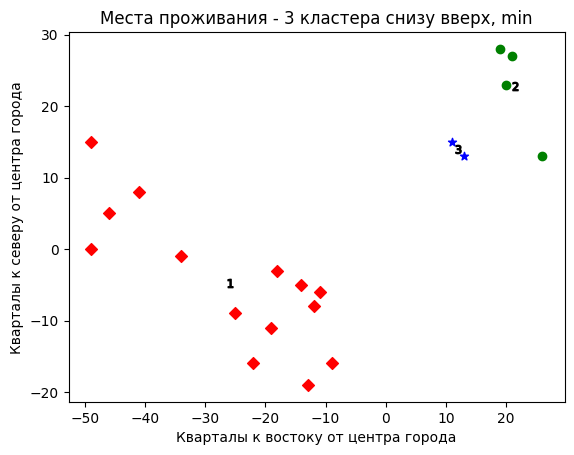

In [26]:
three_clusters = [get_values(cluster)
                  for cluster in generate_clusters(base_cluster, 3)]

for i, cluster, marker, color in zip([1, 2, 3],
                                         three_clusters,
                                         ['D','o','*'],
                                         ['r','g','b']):
        xs, ys = zip(*cluster)  # Распаковка
        plt.scatter(xs, ys, color=color, marker=marker)
    
        # Установить число на среднем значении кластера
        x, y = vector_mean(cluster)
        plt.plot(x, y, marker='$' + str(i) + '$', color='black')
    
plt.title("Места проживания - 3 кластера снизу вверх, min")
plt.xlabel("Кварталы к востоку от центра города")
plt.ylabel("Кварталы к северу от центра города")
plt.show()